# Earthquake data science project

In [1]:
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import exists
import json
from pathlib import Path
import numpy as np
import plotly.express as px

# Definitions

NCEI API contains definitions of certain terms contained in the data. These are read using the descriptors module and shown here.

In [2]:
from descriptors import fetch_descriptor

In [3]:
# ID : Cost of damage
damage = fetch_descriptor('effect/damage')
damage

,id,description
0,0,None
1,1,Limited (<$1 million)
2,2,Moderate (~$1 to $5 million)
3,3,Severe (~>$5 to $24 million)
4,4,Extreme (~$25 million or more)


In [4]:
# ID : Number of houses affected
houses = fetch_descriptor('effect/houses')
houses

,id,description
0,0,None
1,1,Few (~1 to 50 houses)
2,2,Some (~51 to 100 houses)
3,3,Many (~101 to 1000 houses)
4,4,Very Many (~1001 or more houses)


In [5]:
# ID : Number of people affected
people = fetch_descriptor('effect/people')
people

,id,description
0,0,None
1,1,Few (~1 to 50 people)
2,2,Some (~51 to 100 people)
3,3,Many (~101 to 1000 people)
4,4,Very Many (~1001 or more people)


In [6]:
# ID : area of the world
regions = fetch_descriptor('earthquake/regions')
# Edit df for consistency with data columns (read later)
regions.rename({"id": "regionCode"}, axis=1, inplace=True)
regions['regionCode'] = regions['regionCode'].astype(int)
regions.set_index('regionCode', inplace=True)
regions

,description
regionCode,
10,"Central, Western and S. Africa"
15,Northern Africa
20,Antarctica
30,East Asia
40,Central Asia and Caucasus
50,Kamchatka and Kuril Islands
60,S. and SE. Asia and Indian Ocean
70,Atlantic Ocean
80,Bering Sea


# Read data

Data obtained from the API available via the National Centers for Environmental Information (NCEI; formally National Geophysical Data Center (NGDC)).

https://www.ngdc.noaa.gov

Citation: National Geophysical Data Center / World Data Service (NGDC/WDS): NCEI/WDS Global Significant Earthquake Database. NOAA National Centers for Environmental Information. doi:10.7289/V5TD9V7K [23/05/22]

API documentation:
- Click headings in table: https://www.ngdc.noaa.gov/hazel/view/hazards/earthquake/event-data
- List of available descriptors: https://www.ngdc.noaa.gov/hazel/view/swagger#/

The API documentation is not particularly clear so the start of the EDA section below gives descriptions of some of the unclear data columns as I have understood them.

In [7]:
# API url
url = 'https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/earthquakes'

In [8]:
Path("data").mkdir(parents=True, exist_ok=True) # Make directory to hold json files if not already created

In [9]:
# Retrieve data from url and write to json file
urllib.request.urlretrieve(url, 'data/earthquake-data.json')

('data/earthquake-data.json', <http.client.HTTPMessage at 0x1f6b716bb80>)

In [10]:
# Load data using Python JSON module
with open('data/earthquake-data.json','r') as f:
    data = json.loads(f.read())

In [11]:
eq = pd.json_normalize(data, record_path=['items'])
eq.set_index('id', inplace=True)

In [12]:
eq.head()

,year,locationName,latitude,longitude,intensity,damageAmountOrder,publish,damageAmountOrderTotal,country,regionCode,...,eqMagMb,damageMillionsDollars,damageMillionsDollarsTotal,housesDamaged,missingAmountOrderTotal,eqMagMl,missing,missingAmountOrder,missingTotal,eqMagMfa
id,,,,,,,,,,,,,,,,,,,,,
40,17,"TURKEY: IZMIR, EFES, AYDIN, MANISA, ALASEHIR,...",37.850,27.300,10.0,3.0,True,3.0,TURKEY,140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,52,"GREECE: PHILIPPI,DRAMA,KAVALA",41.000,24.300,NaN,3.0,True,NaN,GREECE,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,79,ITALY: NAPLES (NAPOLI),40.821,14.426,10.0,NaN,True,NaN,ITALY,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,93,TURKEY: HELLESPONT,40.600,26.700,NaN,3.0,True,NaN,TURKEY,140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,138,CHINA: GANSU PROVINCE,35.800,103.500,9.0,3.0,True,3.0,CHINA,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory data analysis

## Structure

In [13]:
eq.shape

(6318, 48)

In [14]:
eq.columns

Index(['year', 'locationName', 'latitude', 'longitude', 'intensity',
       'damageAmountOrder', 'publish', 'damageAmountOrderTotal', 'country',
       'regionCode', 'second', 'month', 'day', 'tsunamiEventId',
       'volcanoEventId', 'deathsTotal', 'deathsAmountOrderTotal',
       'deathsAmountOrder', 'eqMagnitude', 'housesDestroyedAmountOrder',
       'eqMagMs', 'housesDestroyedAmountOrderTotal', 'deaths', 'eqDepth',
       'eqMagUnk', 'hour', 'minute', 'housesDestroyedTotal', 'housesDestroyed',
       'injuriesAmountOrder', 'injuriesAmountOrderTotal',
       'housesDamagedAmountOrder', 'housesDamagedAmountOrderTotal', 'eqMagMw',
       'housesDamagedTotal', 'injuries', 'injuriesTotal', 'area', 'eqMagMb',
       'damageMillionsDollars', 'damageMillionsDollarsTotal', 'housesDamaged',
       'missingAmountOrderTotal', 'eqMagMl', 'missing', 'missingAmountOrder',
       'missingTotal', 'eqMagMfa'],
      dtype='object')

In [15]:
eq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6318 entries, 40 to 10627
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             6318 non-null   int64  
 1   locationName                     6317 non-null   object 
 2   latitude                         6266 non-null   float64
 3   longitude                        6266 non-null   float64
 4   intensity                        3001 non-null   float64
 5   damageAmountOrder                4561 non-null   float64
 6   publish                          6318 non-null   bool   
 7   damageAmountOrderTotal           3579 non-null   float64
 8   country                          6317 non-null   object 
 9   regionCode                       6318 non-null   int64  
 10  second                           4407 non-null   float64
 11  month                            5907 non-null   float64
 12  day               

- Lots of missing data that will be dealt with later.
- Some datatypes can be changed (e.g. year, month etc).

API documentation states that e.g. deathsTotal is the total number of deaths from the earthquake as well as its secondary effects, such as tsunamis and volcanoes. Same for missing, damage etc.

When a column contains 'AmountOrder', e.g. deathsAmountOrder, the value represents a classification of the number of deaths. In literature, the exact number of deaths is not always recorded so has to be estimated based on other factors.  For cases where the exact number of deaths is given, a classification is still given for completeness.

In [16]:
eq.describe(exclude='number')

,locationName,publish,country,area
count,6317,6318,6317,326
unique,3925,1,156,32
top,CHINA: YUNNAN PROVINCE,True,CHINA,CA
freq,68,6318,614,103


- Country with most earthquakes is China, specifically the Yunnan province.
- 'publish' is true in every case (unclear from API documentation what this is - possibly whether earthquake details are published somewhere?).
- Area with most earthquakes is CA. These appear to be North American state codes (see here for list: https://www.fs.fed.us/database/feis/format.html) so CA is California.
- Seems to be overlap between 'area' and 'locationName'.  'area' could be expanded to non-NA states by extracting the location from 'locationName'. Could use 'country' for this.  Or vice verse, could add 'area' to 'locationName'.

In [17]:
eq.iloc[:, 0:10].describe() # Show 9 columns only so whole df is shown and can be discussed bit by bit

,year,latitude,longitude,intensity,damageAmountOrder,damageAmountOrderTotal,regionCode
count,6318.000000,6266.000000,6266.000000,3001.000000,4561.000000,3579.000000,6318.000000
mean,1807.864039,22.342893,38.052327,8.244918,2.271651,2.219614,106.908041
std,374.694470,22.897905,86.775654,1.804530,0.957934,1.023123,53.658424
min,-2150.000000,-62.877000,-179.984000,2.000000,1.000000,1.000000,10.000000
25%,1822.000000,9.308500,-8.000000,7.000000,2.000000,1.000000,50.000000
50%,1929.000000,32.000000,43.374500,8.000000,2.000000,2.000000,130.000000
75%,1990.000000,38.700000,115.317250,10.000000,3.000000,3.000000,150.000000
max,2022.000000,73.122000,180.000000,12.000000,4.000000,4.000000,170.000000


- Dataset consists of earthquakes recorded from 2150BC to 2022AD. Most are more recent than ~1800.
- 'intensity' is actually the MMI intensity (modified Mercalli intensity) - values range from 1 to 12 where 1 is "not felt other than in especially favorable circumstances" and 12 is "Damage total - waves seen on ground surface and line of sight distorted".
- 'damageAmountOrder' is a five-level scale used to classify damage (based on current U.S. dollars). See 'damage' dataframe in Definitions section for what each code means. This was required as exact amount of damage not always clear from literature. 'damageAmountOrderTotal' is the same except also includes the earthquakes secondary effects.
- 'regionCode' is an integer code corresponding to the region of the World. See 'regions' dataframe in Definitions section for what each code means.

In [18]:
eq.iloc[:, 10:19].describe()

,second,month,day,tsunamiEventId,volcanoEventId,deathsTotal,deathsAmountOrderTotal,deathsAmountOrder,eqMagnitude
count,4407.000000,5907.000000,5751.000000,1947.000000,76.000000,1892.000000,2257.000000,2594.000000,4539.000000
mean,19.754482,6.498053,15.757955,2283.941962,3700.065789,3910.995772,1.960567,2.003084,6.451443
std,19.666225,3.449965,8.735067,1691.273784,2430.765769,26926.908454,1.166443,1.154140,1.039489
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.600000
25%,0.000000,4.000000,8.000000,1021.500000,1345.000000,3.000000,1.000000,1.000000,5.700000
50%,14.700000,7.000000,16.000000,1883.000000,3748.500000,18.000000,1.000000,1.000000,6.500000
75%,36.800000,9.000000,23.000000,3165.500000,5364.750000,256.000000,3.000000,3.000000,7.300000
max,59.900000,12.000000,31.000000,5850.000000,7542.000000,830000.000000,4.000000,4.000000,9.500000


- 'second', 'month' and 'day' can be combined into datetime object later (with other time related columns).
- 'tsunamiEventId' and 'volcanoEventId' are the id number of the tsunami/volcano eruption caused by each earthquake, if applicable.
- 'deathsTotal' likely contains some outliers as mean long way from median.
- eqMagnitude is the standard earthquake magnitude measurement (energy released at the source of the earthquake).  For pre-instrumental events, the magnitudes are derived from intensities.

In [19]:
eq.iloc[:, 19:30].describe()

,housesDestroyedAmountOrder,eqMagMs,housesDestroyedAmountOrderTotal,deaths,eqDepth,eqMagUnk,hour,minute,housesDestroyedTotal,housesDestroyed,injuriesAmountOrder
count,1814.000000,2983.000000,1896.000000,2111.000000,3344.000000,793.000000,4265.000000,4061.000000,8.730000e+02,8.410000e+02,1544.000000
mean,2.678611,6.566879,2.686181,3719.004263,40.479665,6.654098,11.301758,28.724206,1.767129e+04,1.713627e+04,1.955959
std,1.061181,0.988320,1.055774,25138.207809,69.731699,1.004704,7.016441,17.175758,1.892456e+05,1.911632e+05,1.078574
min,0.000000,2.100000,1.000000,1.000000,0.000000,3.200000,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000
25%,2.000000,5.800000,2.000000,3.000000,10.000000,6.000000,5.000000,14.000000,6.600000e+01,6.700000e+01,1.000000
50%,3.000000,6.600000,3.000000,21.000000,25.000000,6.800000,11.000000,29.000000,5.060000e+02,5.060000e+02,1.000000
75%,3.000000,7.300000,3.000000,300.000000,39.000000,7.500000,17.000000,43.000000,3.400000e+03,3.600000e+03,3.000000
max,4.000000,9.100000,4.000000,830000.000000,675.000000,8.800000,23.000000,59.000000,5.360000e+06,5.360000e+06,4.000000


- There are various magnitude scales used to measure earthquakes. These are X=[Mw, Ms, Mb, Ml, Mfa, Unknown] and are shown in the eqMagX columns. The value given in 'eqMagnitude' is chosen based on what is available, in the order of X.
- 'eqDepth' is the depth of the earthquake measured in km. Looks like most earthquakes occur shallower than the mean depth.

In [20]:
eq.iloc[:, 30:40].describe()

,injuriesAmountOrderTotal,housesDamagedAmountOrder,housesDamagedAmountOrderTotal,eqMagMw,housesDamagedTotal,injuries,injuriesTotal,eqMagMb,damageMillionsDollars
count,1565.000000,1035.000000,925.000000,1530.000000,4.710000e+02,1325.000000,1346.000000,1822.000000,540.000000
mean,1.953355,2.560386,2.514595,6.503725,5.439803e+04,2180.530566,2364.283804,5.790450,1208.431502
std,1.075653,1.119104,1.132486,0.907216,9.678941e+05,25624.632848,26683.306001,0.726699,6553.597118
min,1.000000,1.000000,1.000000,3.600000,1.000000e+00,1.000000,1.000000,2.100000,0.013000
25%,1.000000,2.000000,1.000000,5.800000,1.000000e+02,10.000000,10.000000,5.300000,4.000000
50%,1.000000,3.000000,3.000000,6.400000,7.000000e+02,40.000000,41.000000,5.800000,24.400000
75%,3.000000,4.000000,4.000000,7.200000,3.071000e+03,200.000000,200.000000,6.300000,228.175000
max,4.000000,4.000000,4.000000,9.500000,2.100000e+07,799000.000000,799000.000000,8.200000,100000.000000


- 'damageMillionsDollars' is the exact amount of damage caused by the earthquake (based on the current dollar value). This is what is used to place the earthquake in a 'damageAmountOrder' category, if it is available.

In [21]:
eq.iloc[:, 40:49].describe() # End of dataframe columns

,damageMillionsDollarsTotal,housesDamaged,missingAmountOrderTotal,eqMagMl,missing,missingAmountOrder,missingTotal,eqMagMfa
count,512.000000,5.270000e+02,32.000000,188.000000,25.000000,25.000000,28.000000,14.000000
mean,1714.700125,2.411315e+04,1.781250,5.380319,1864.440000,1.760000,1734.392857,6.771429
std,11780.202066,2.408365e+05,1.039056,1.110565,8672.299638,0.969536,8189.406361,1.230027
min,0.010000,1.000000e+00,1.000000,1.600000,1.000000,1.000000,1.000000,4.300000
25%,4.875000,9.100000e+01,1.000000,4.700000,4.000000,1.000000,3.750000,6.225000
50%,27.135500,7.000000e+02,1.000000,5.400000,17.000000,1.000000,25.500000,7.050000
75%,285.125000,3.850000e+03,3.000000,6.025000,114.000000,3.000000,153.500000,7.475000
max,220136.600000,5.360000e+06,4.000000,7.700000,43476.000000,4.000000,43476.000000,8.500000


- 'missing' is the number of people missing.

In [22]:
eq.shape

(6318, 48)

Based on the above points, clean up the dataframe:

In [23]:
# Remove 'publish' column
eq.drop('publish', axis=1, inplace=True)

In [24]:
# Combine year, month, day columns into one (negative years converted to NaT but will likely be dropped after EDA is complete)
eq['date'] = pd.to_datetime(eq[['year','month', 'day']], errors='coerce')
# Keep year column (for EDA later) but drop month and day
eq.drop(['month', 'day'], axis=1, inplace=True)

In [25]:
# hour, minute, second is not interesting and is also missing from ~1/3 of dataset so remove
eq.drop(['hour', 'minute', 'second'], axis=1, inplace=True)

In [26]:
eq.columns

Index(['year', 'locationName', 'latitude', 'longitude', 'intensity',
       'damageAmountOrder', 'damageAmountOrderTotal', 'country', 'regionCode',
       'tsunamiEventId', 'volcanoEventId', 'deathsTotal',
       'deathsAmountOrderTotal', 'deathsAmountOrder', 'eqMagnitude',
       'housesDestroyedAmountOrder', 'eqMagMs',
       'housesDestroyedAmountOrderTotal', 'deaths', 'eqDepth', 'eqMagUnk',
       'housesDestroyedTotal', 'housesDestroyed', 'injuriesAmountOrder',
       'injuriesAmountOrderTotal', 'housesDamagedAmountOrder',
       'housesDamagedAmountOrderTotal', 'eqMagMw', 'housesDamagedTotal',
       'injuries', 'injuriesTotal', 'area', 'eqMagMb', 'damageMillionsDollars',
       'damageMillionsDollarsTotal', 'housesDamaged',
       'missingAmountOrderTotal', 'eqMagMl', 'missing', 'missingAmountOrder',
       'missingTotal', 'eqMagMfa', 'date'],
      dtype='object')

In [27]:
# Rename intensity to mm_intensity for consistency with API docs
eq.rename(columns={"intensity": "mm_intensity"}, inplace=True)

In [28]:
# Replace regionCode with region name according to definitions held in 'regions' dataframe
eq['region'] = eq['regionCode'].map(regions['description'], na_action='ignore')
eq.drop('regionCode', axis=1, inplace=True)

In [29]:
# Rename eqMagnitude and eqDepth
eq.rename(columns={"eqMagnitude": "magnitude", "eqDepth": "depth"}, inplace=True)

In [30]:
# Drop alternative magnitude measurements (the one used as 'magnitude' is the first that exists out of
# [Mw, Ms, Mb, Ml, Mfa, Unknown] so the breakdown is not required here)
eq.drop(['eqMagMw', 'eqMagMs', 'eqMagMb', 'eqMagMl', 'eqMagMfa', 'eqMagUnk'], axis=1, inplace=True)

In [31]:
eq.columns

Index(['year', 'locationName', 'latitude', 'longitude', 'mm_intensity',
       'damageAmountOrder', 'damageAmountOrderTotal', 'country',
       'tsunamiEventId', 'volcanoEventId', 'deathsTotal',
       'deathsAmountOrderTotal', 'deathsAmountOrder', 'magnitude',
       'housesDestroyedAmountOrder', 'housesDestroyedAmountOrderTotal',
       'deaths', 'depth', 'housesDestroyedTotal', 'housesDestroyed',
       'injuriesAmountOrder', 'injuriesAmountOrderTotal',
       'housesDamagedAmountOrder', 'housesDamagedAmountOrderTotal',
       'housesDamagedTotal', 'injuries', 'injuriesTotal', 'area',
       'damageMillionsDollars', 'damageMillionsDollarsTotal', 'housesDamaged',
       'missingAmountOrderTotal', 'missing', 'missingAmountOrder',
       'missingTotal', 'date', 'region'],
      dtype='object')

In [32]:
# Rename damage columns so they are consistent with the other columns naming scheme
eq.rename(columns={'damageAmountOrder': 'damageMillionsDollarsAmountOrder',
                   'damageAmountOrderTotal': 'damageMillionsDollarsAmountOrderTotal'},
          inplace=True)

In [33]:
# Remove columns that are a combination of earthquake+secondary effects
effects = ['deaths', 'damageMillionsDollars', 'housesDestroyed', 'injuries', 'housesDamaged', 'missing']
for e in effects:
    eq.drop([e+'Total', e+'AmountOrderTotal'], axis=1, inplace=True) # Drop combined earthquake, volcano and tsunami effects
    eq.rename(columns={e+'AmountOrder': e+'Category'}, inplace=True) # Rename column to something that makes more sense

In [34]:
eq.shape

(6318, 25)

In [35]:
# Re-order columns
eq = eq.reindex(columns=['date', 'year', 'region', 'locationName', 'country', 'area', 'latitude', 'longitude', 'magnitude',
                         'mm_intensity', 'depth', 'deaths', 'deathsCategory', 'missing', 'missingCategory', 'injuries',
                         'injuriesCategory', 'housesDestroyed', 'housesDestroyedCategory', 'housesDamaged',
                         'housesDamagedCategory', 'damageMillionsDollars', 'damageMillionsDollarsCategory',
                         'tsunamiEventId', 'volcanoEventId'])

In [36]:
eq.shape

(6318, 25)

In [37]:
eq.columns

Index(['date', 'year', 'region', 'locationName', 'country', 'area', 'latitude',
       'longitude', 'magnitude', 'mm_intensity', 'depth', 'deaths',
       'deathsCategory', 'missing', 'missingCategory', 'injuries',
       'injuriesCategory', 'housesDestroyed', 'housesDestroyedCategory',
       'housesDamaged', 'housesDamagedCategory', 'damageMillionsDollars',
       'damageMillionsDollarsCategory', 'tsunamiEventId', 'volcanoEventId'],
      dtype='object')

## Quality

In [38]:
# Check for duplicates
eq.duplicated().sum()

3

In [39]:
eq[eq.duplicated() == True]

,date,year,region,locationName,country,area,latitude,longitude,magnitude,mm_intensity,...,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollars,damageMillionsDollarsCategory,tsunamiEventId,volcanoEventId
id,,,,,,,,,,,,,,,,,,,,,
686,NaT,1516,Southern Europe,BALKANS NW: CROATIA,CROATIA,NaN,42.6,18.1,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
605,NaT,1454,Northern and Western Europe,SWITZERLAND,SWITZERLAND,NaN,47.5,7.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,NaT,1280,Southern Europe,BALKANS NW: CROATIA,CROATIA,NaN,44.1,15.2,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Remove duplicates
eq.drop_duplicates(inplace=True)

In [41]:
eq.shape

(6315, 25)

In [42]:
# Check for rows with large sections of missing data
import missingno as msno

<AxesSubplot:>

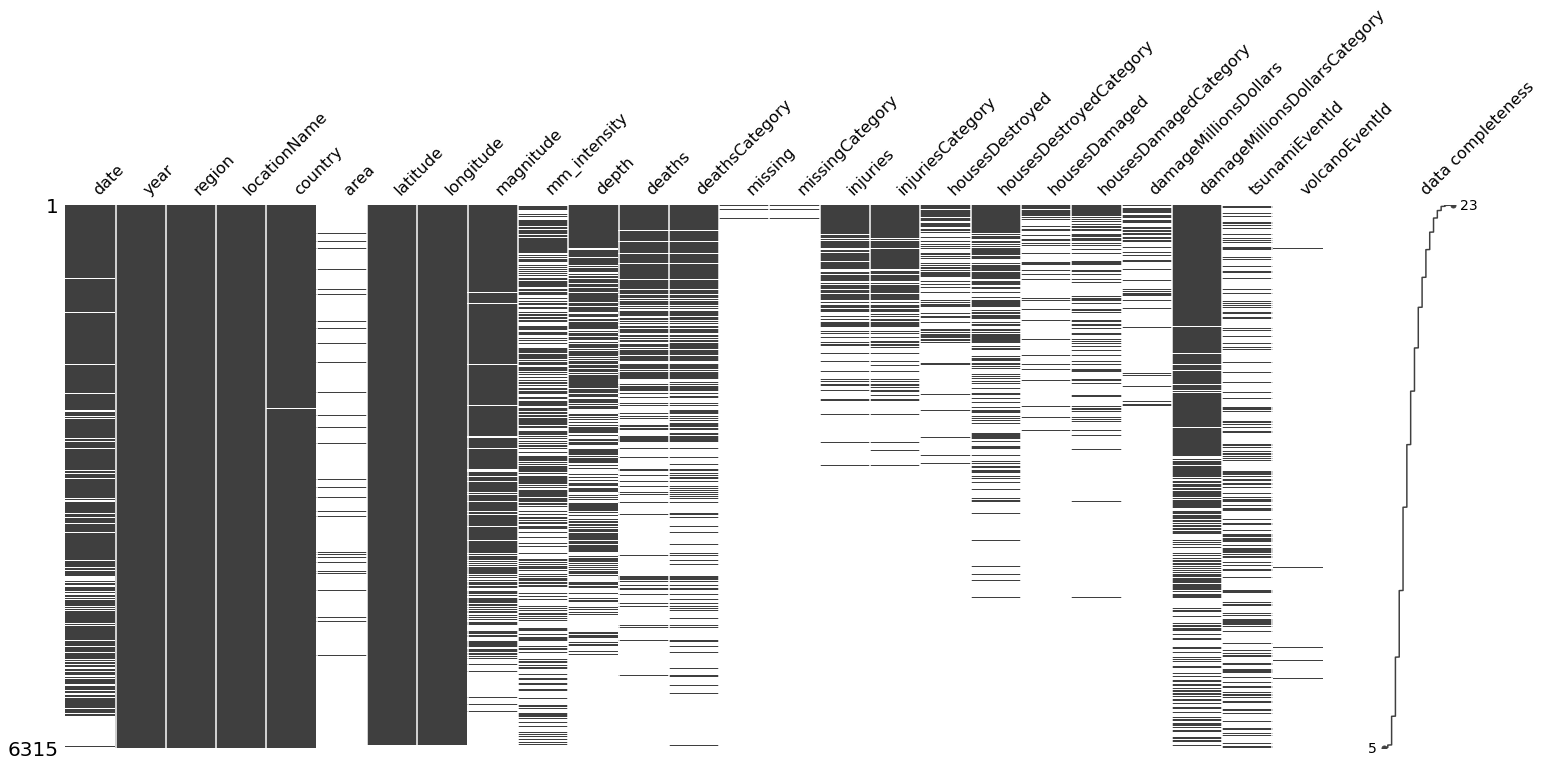

In [43]:
msno.matrix(eq, labels=True, sort='descending')

Lots of missing data! Are any of the missing points correlated?

<AxesSubplot:>

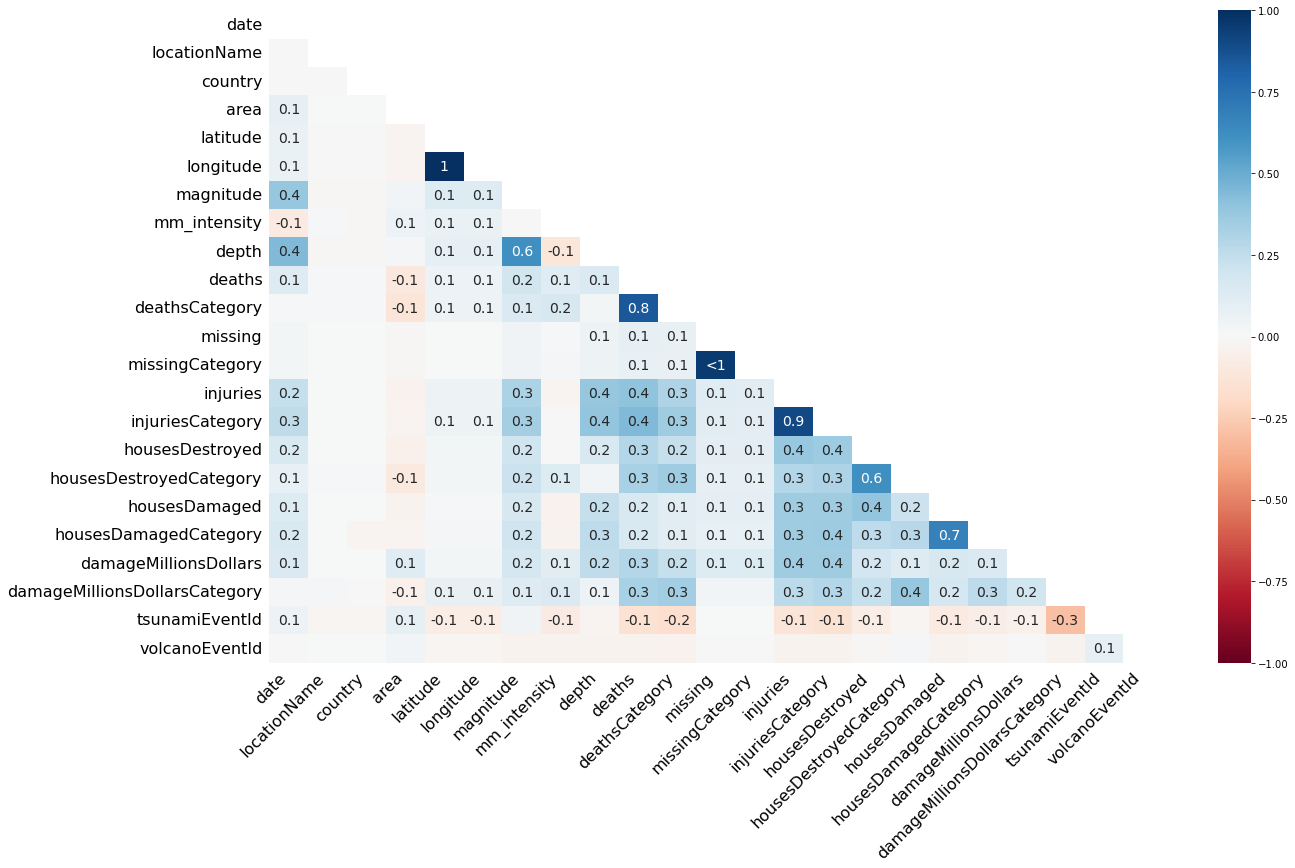

In [44]:
msno.heatmap(eq)

High positive correlation between e.g. 'deaths' and 'deathsCategory' missing value as one would expect.

The correlation between e.g. 'magnitude' and 'date' missing values (as well as other positive correlations present) is presumably earthquakes from the non-modern era where little is known about them.

Before investigating rows with lots of missing data, check the number of missing values per feature.

Text(0, 0.5, 'Proportion of missing values per feature')

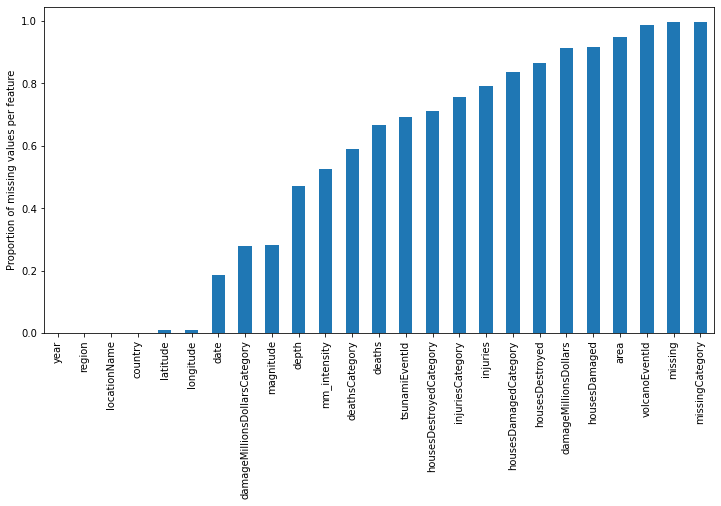

In [47]:
eq.isna().mean().sort_values().plot(kind='bar', figsize=(12,6))
plt.ylabel('Proportion of missing values per feature')

Can I predict the number of:
- deaths based on the location/magnitude/damage/depth?
- injuries based on the number of deaths?
- houses damaged/destroyed based on location/magnitude/damage/depth/damage?

The area column can possibly be combined with region/locationName, as mentioned earlier.

Exact amount of damageMillionsDollars is missing in a large number of cases but the damageMillionsDollarsCategory does not have too many missing points.

Will try to fill some of the missing data points as described above. Drop the features where there are too many missing or if a different category provides a better measurement of a similar feature.

In [48]:
# Drop features with too many missing datapoints
eq.drop(['missing', 'missingCategory', 'damageMillionsDollars'], axis=1, inplace=True)
# Also drop 'mm_intensity' as 'magnitude' provides a similar measurement and has far fewer missing points
eq.drop('mm_intensity', axis=1, inplace=True)

Text(0, 0.5, 'Proportion of missing values per feature')

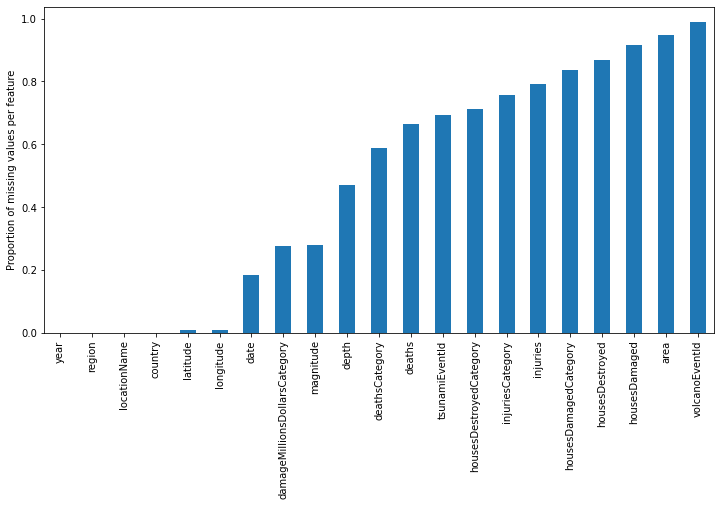

In [49]:
eq.isna().mean().sort_values().plot(kind='bar', figsize=(12,6))
plt.ylabel('Proportion of missing values per feature')

In [63]:
# Entries with no tsunami and volcano event ID mean neither occured. Replace with 0/1 depending on if a secondary event occured
# or not
eq['caused_tsunami'] = eq['tsunamiEventId'].apply(lambda x: 0 if np.isnan(x) else 1)
eq['caused_volcano'] = eq['volcanoEventId'].apply(lambda x: 0 if np.isnan(x) else 1)
eq.drop(['tsunamiEventId', 'volcanoEventId'], axis=1, inplace=True)

In [64]:
eq.columns

Index(['date', 'year', 'region', 'locationName', 'country', 'area', 'latitude',
       'longitude', 'magnitude', 'depth', 'deaths', 'deathsCategory',
       'injuries', 'injuriesCategory', 'housesDestroyed',
       'housesDestroyedCategory', 'housesDamaged', 'housesDamagedCategory',
       'damageMillionsDollarsCategory', 'caused_tsunami', 'caused_volcano'],
      dtype='object')

Text(0, 0.5, 'Proportion of missing values per feature')

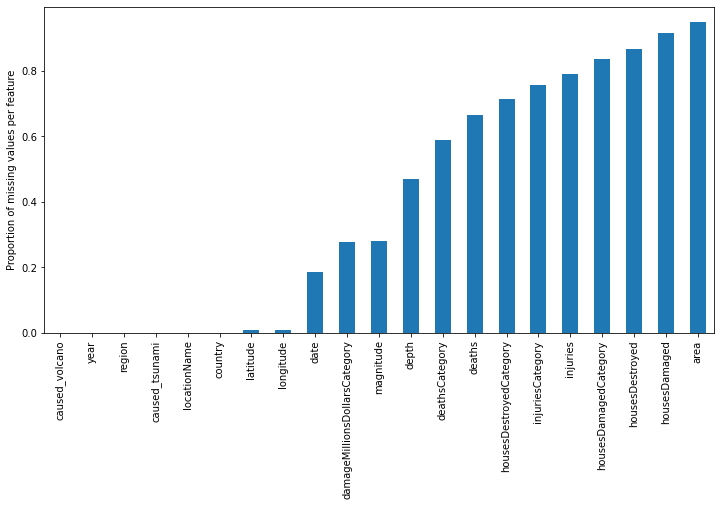

In [65]:
eq.isna().mean().sort_values().plot(kind='bar', figsize=(12,6))
plt.ylabel('Proportion of missing values per feature')

In [66]:
# What dates are missing?
eq[eq['date'].isna()]

,date,year,region,locationName,country,area,latitude,longitude,magnitude,depth,...,deathsCategory,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,,,,,,,,,
40,NaT,17,Middle East,"TURKEY: IZMIR, EFES, AYDIN, MANISA, ALASEHIR,...",TURKEY,NaN,37.850,27.300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
49,NaT,52,Southern Europe,"GREECE: PHILIPPI,DRAMA,KAVALA",GREECE,NaN,41.000,24.300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
58,NaT,79,Southern Europe,ITALY: NAPLES (NAPOLI),ITALY,NaN,40.821,14.426,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
61,NaT,93,Middle East,TURKEY: HELLESPONT,TURKEY,NaN,40.600,26.700,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
66,NaT,138,East Asia,CHINA: GANSU PROVINCE,CHINA,NaN,35.800,103.500,6.8,NaN,...,3.0,NaN,NaN,NaN,3.0,NaN,NaN,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9947,NaT,1255,S. and SE. Asia and Indian Ocean,NEPAL: KATHMANDU,NEPAL,NaN,27.700,85.300,NaN,NaN,...,3.0,NaN,NaN,NaN,3.0,NaN,NaN,3.0,0,0
9969,NaT,120,Middle East,"TURKEY: NICOMEDIA, NICAEA",TURKEY,NaN,40.770,29.920,7.2,NaN,...,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,1,0
10066,NaT,1831,Central and South Pacific,NEW ZEALAND: NORTH ISLAND: POVERTY BAY,NEW ZEALAND,NaN,-38.700,178.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [72]:
eq[eq['date'].isna()]['year'].describe()

count    1171.000000
mean     1250.855679
std       589.516146
min     -2150.000000
25%      1011.500000
50%      1493.000000
75%      1641.000000
max      1957.000000
Name: year, dtype: float64

In [75]:
eq[eq['year'].isna()]

,date,year,region,locationName,country,area,latitude,longitude,magnitude,depth,...,deathsCategory,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,,,,,,,,,


In [76]:
# On second thoughts, will likely gain more info from keeping year (inc. negative years) than dropping values that can't
# be converted to pd.datetime objects. So drop 'date' and keep 'year'.
eq.drop('date', axis=1, inplace=True)

In [78]:
# What about 'area'? This represents the US county code
eq[eq['area'].notnull()]

,year,region,locationName,country,area,latitude,longitude,magnitude,depth,deaths,deathsCategory,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,,,,,,,,
1693,1825,Central and South Pacific,GUAM; NORTHERN MARIANA ISLANDS: LADRONES ISLAND,USA TERRITORY,GU,14.000,143.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,1,0
2419,1892,Central and South Pacific,GUAM,USA TERRITORY,GU,14.000,143.300,7.5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,1,0
2533,1898,North America and Hawaii,"CALIFORNIA: N COAST,MENDOCINO COUNTY",USA,CA,39.000,-124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0
2554,1899,North America and Hawaii,ALASKA: CAPE YAKATAGA,USA,AK,60.000,-140.000,7.8,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2606,1902,North America and Hawaii,ALASKA: ALEUTIAN ISLANDS: FOX ISLANDS,USA,AK,52.400,-167.500,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9954,1700,North America and Hawaii,CASCADIA SUBDUCTION ZONE,USA,OR,45.000,-125.000,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
10036,2013,North America and Hawaii,TEXAS: WEST,USA,TX,31.817,-97.088,2.1,0.0,14.0,1.0,200.0,3.0,50.0,1.0,NaN,NaN,4.0,0,0
10157,2015,North America and Hawaii,ALASKA,USA,AK,52.214,-169.399,6.9,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [79]:
# We already have this information in 'locationName' and latitude/longitude so drop
eq.drop('area', axis=1, inplace=True)

In [80]:
eq

,year,region,locationName,country,latitude,longitude,magnitude,depth,deaths,deathsCategory,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,,,,,,,
40,17,Middle East,"TURKEY: IZMIR, EFES, AYDIN, MANISA, ALASEHIR,...",TURKEY,37.850,27.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
49,52,Southern Europe,"GREECE: PHILIPPI,DRAMA,KAVALA",GREECE,41.000,24.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
58,79,Southern Europe,ITALY: NAPLES (NAPOLI),ITALY,40.821,14.426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
61,93,Middle East,TURKEY: HELLESPONT,TURKEY,40.600,26.700,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
66,138,East Asia,CHINA: GANSU PROVINCE,CHINA,35.800,103.500,6.8,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10613,1959,Central Asia and Caucasus,RUSSIA: LAKE BAYKAL (BAIKAL),RUSSIA,52.000,106.500,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
10617,2022,South America,"PERU: LIMA, CALLAO, CHILCA",PERU,-12.360,-76.890,5.4,55.0,2.0,1.0,11.0,1.0,4.0,1.0,4.0,1.0,1.0,0,0
10619,1875,Southern Europe,"ITALY: RIMINI, CERVIA, CESENATICO",ITALY,44.200,12.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0


Text(0, 0.5, 'Proportion of missing values per feature')

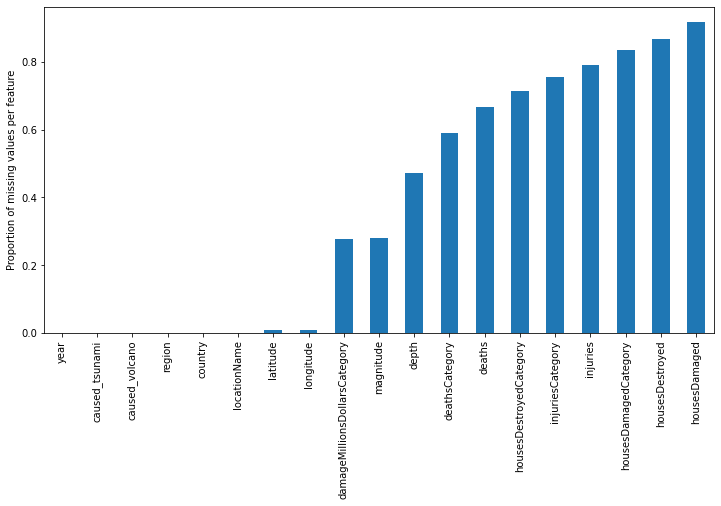

In [81]:
eq.isna().mean().sort_values().plot(kind='bar', figsize=(12,6))
plt.ylabel('Proportion of missing values per feature')

In [82]:
# Realistically, too much missing data in below columns so drop
eq.drop(['housesDamaged', 'housesDestroyed', 'housesDamagedCategory', 'injuries', 'injuriesCategory', 'housesDestroyedCategory'],
       axis=1, inplace=True)

In [83]:
eq

,year,region,locationName,country,latitude,longitude,magnitude,depth,deaths,deathsCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,
40,17,Middle East,"TURKEY: IZMIR, EFES, AYDIN, MANISA, ALASEHIR,...",TURKEY,37.850,27.300,NaN,NaN,NaN,NaN,3.0,0,0
49,52,Southern Europe,"GREECE: PHILIPPI,DRAMA,KAVALA",GREECE,41.000,24.300,NaN,NaN,NaN,NaN,3.0,0,0
58,79,Southern Europe,ITALY: NAPLES (NAPOLI),ITALY,40.821,14.426,NaN,NaN,NaN,NaN,NaN,1,1
61,93,Middle East,TURKEY: HELLESPONT,TURKEY,40.600,26.700,NaN,NaN,NaN,3.0,3.0,0,0
66,138,East Asia,CHINA: GANSU PROVINCE,CHINA,35.800,103.500,6.8,NaN,NaN,3.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10613,1959,Central Asia and Caucasus,RUSSIA: LAKE BAYKAL (BAIKAL),RUSSIA,52.000,106.500,6.5,NaN,NaN,NaN,NaN,1,0
10617,2022,South America,"PERU: LIMA, CALLAO, CHILCA",PERU,-12.360,-76.890,5.4,55.0,2.0,1.0,1.0,0,0
10619,1875,Southern Europe,"ITALY: RIMINI, CERVIA, CESENATICO",ITALY,44.200,12.400,NaN,NaN,NaN,NaN,2.0,1,0


<AxesSubplot:>

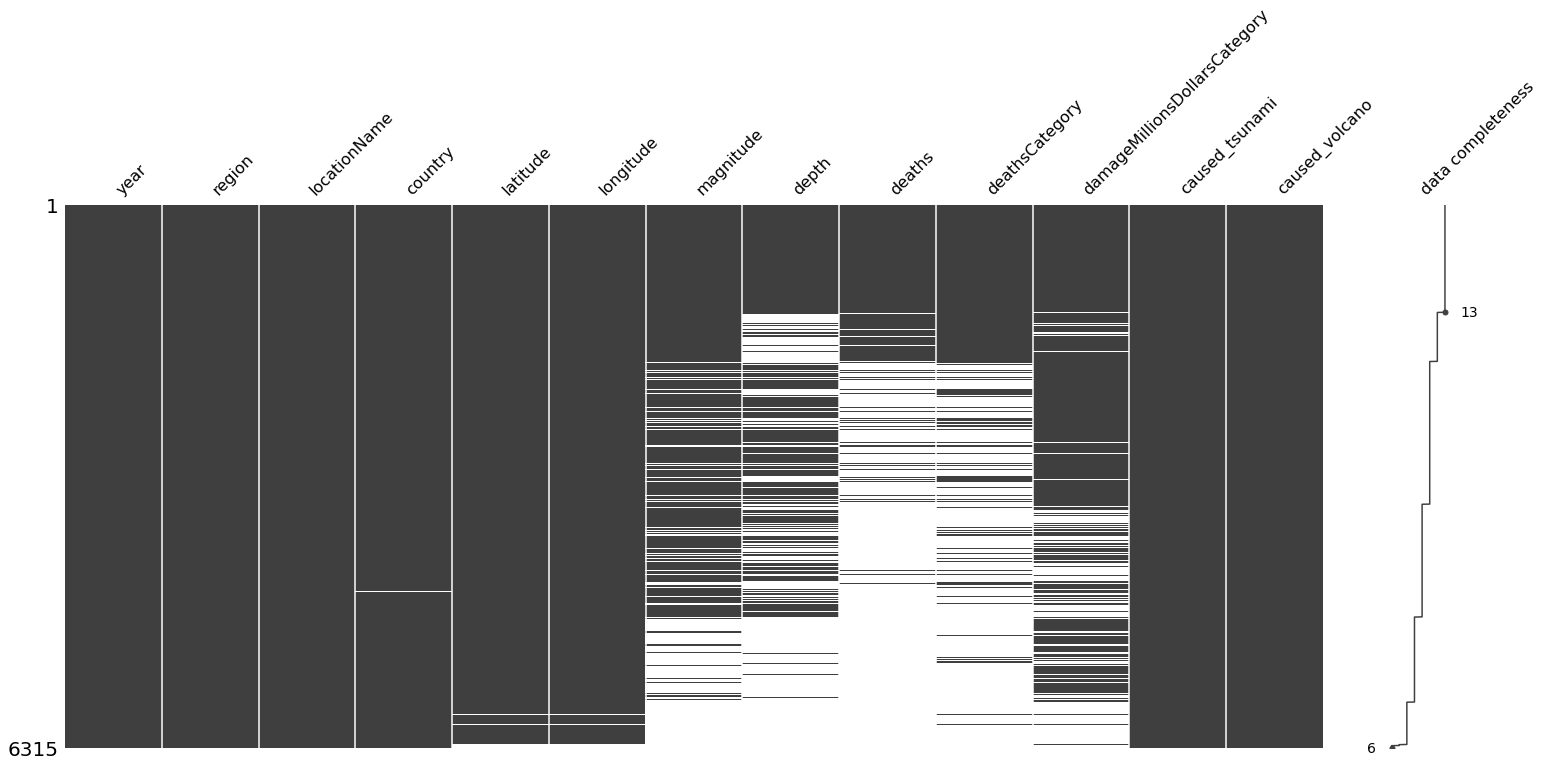

In [84]:
msno.matrix(eq, labels=True, sort='descending')

<AxesSubplot:ylabel='Frequency'>

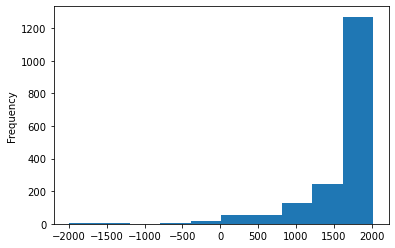

In [89]:
eq[eq['magnitude'].isnull()]['year'].plot(kind='hist')

In [92]:
# Drop entries where magnitude is missing, likely to be an important feature!
eq.drop(eq[eq['magnitude'].isnull()].index, inplace=True)

<AxesSubplot:>

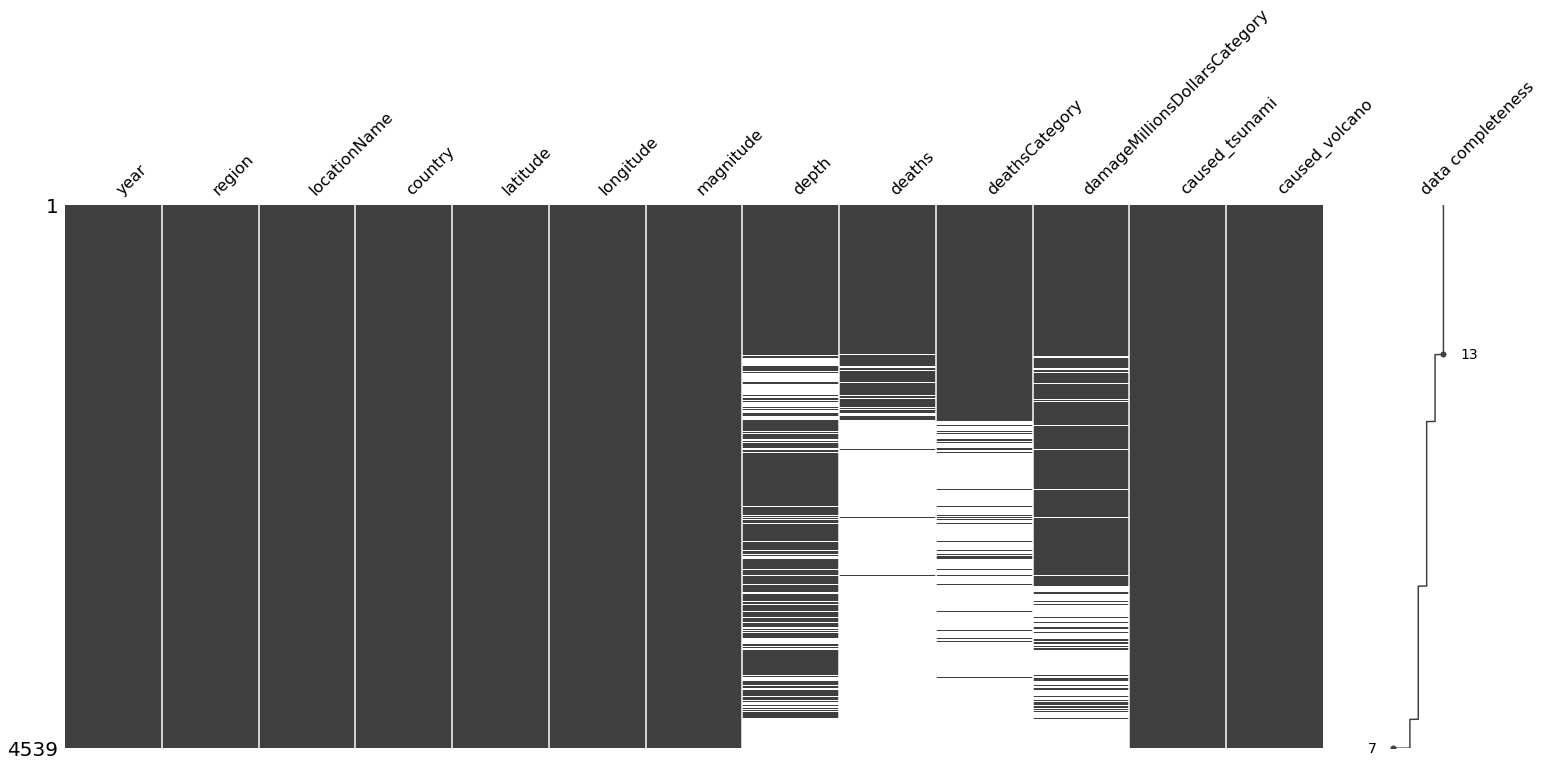

In [93]:
msno.matrix(eq, labels=True, sort='descending')

Text(0, 0.5, 'depth')

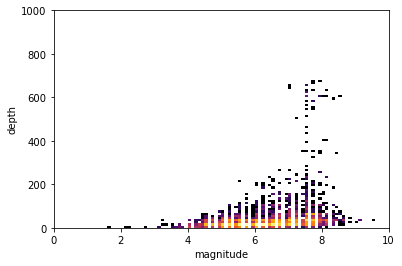

In [120]:
from matplotlib import colors
# Can the depth column missing values be filled based on the magnitude of the earthquake?
plt.hist2d(eq['magnitude'], eq['depth'], range=[[0,10],[0,1000]], bins=100, cmap='inferno', norm=colors.LogNorm())#, s=2)
plt.xlabel('magnitude')
plt.ylabel('depth')

In [102]:
# Although deeper earthquakes tend to be larger in magnitude, unlikely to be able to predict the shallower earthquakes well

<AxesSubplot:xlabel='caused_tsunami', ylabel='depth'>

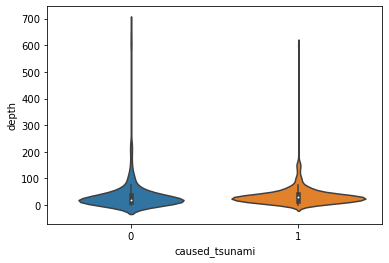

In [106]:
# Does whether a tsunami/volcano occured help predict depth?
sns.violinplot(data=eq, x='caused_tsunami', y='depth')

<AxesSubplot:xlabel='caused_volcano', ylabel='depth'>

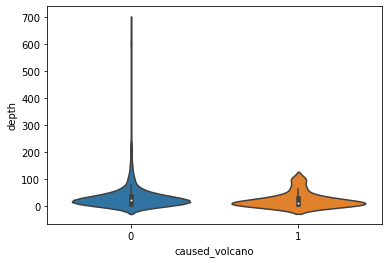

In [110]:
sns.violinplot(data=eq, x='caused_volcano', y='depth')

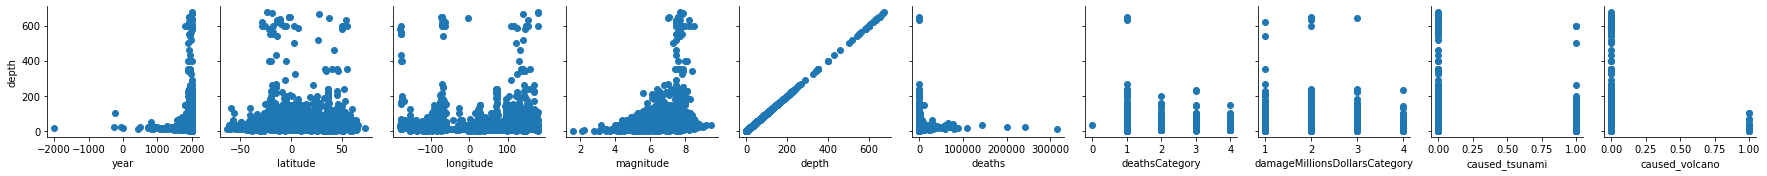

In [140]:
g = sns.PairGrid(eq, y_vars='depth')    
g = g.map(plt.scatter)

In [146]:
# No obvious variable that could be used to predict depth (some apparently strange features here, to be looked at later)
# Drop entries with depth missing
eq.drop(eq[eq['depth'].isnull()].index, inplace=True)

<AxesSubplot:>

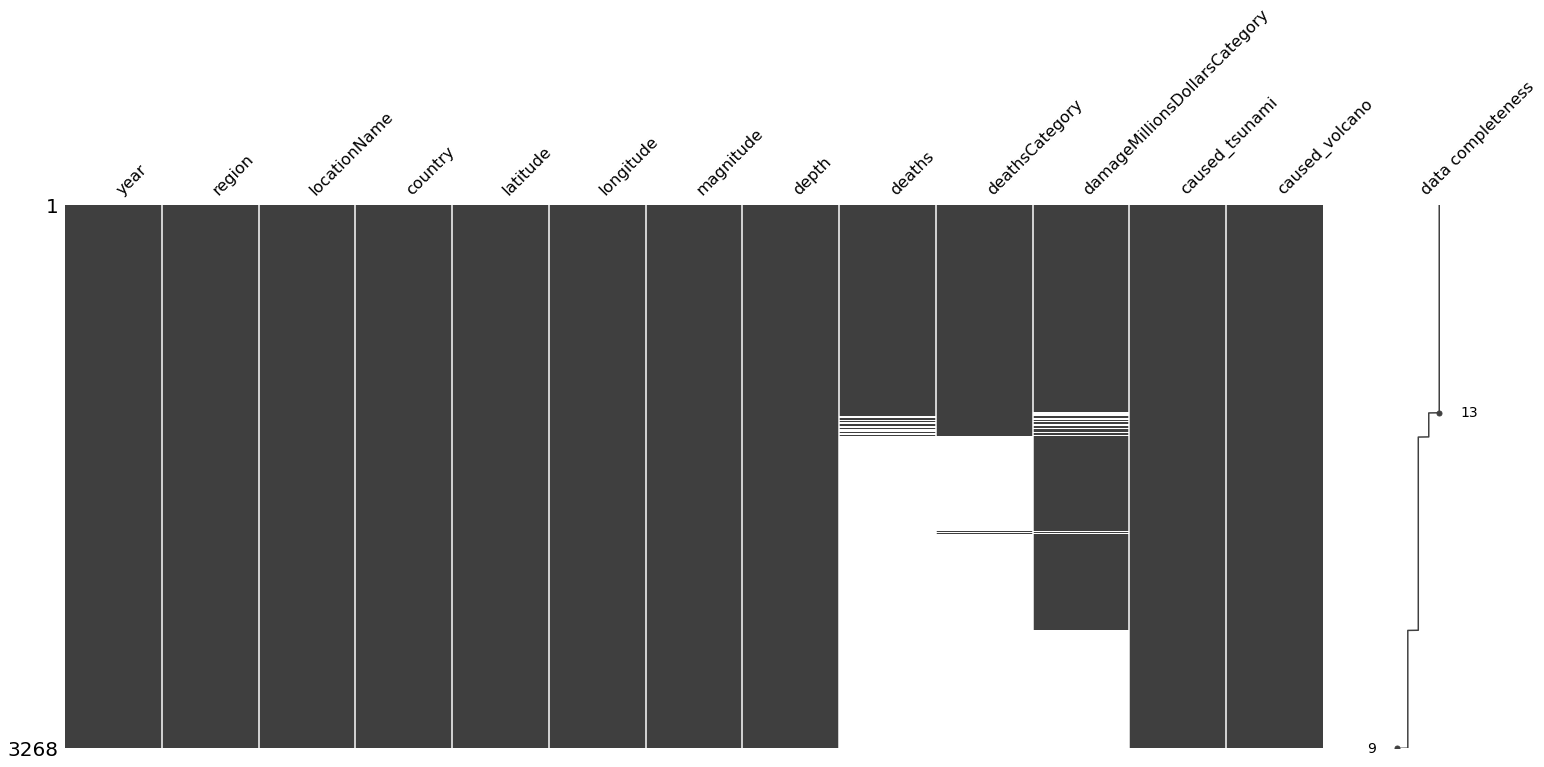

In [147]:
msno.matrix(eq, labels=True, sort='descending')

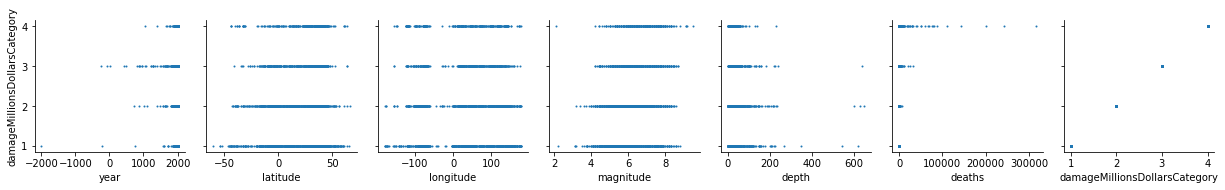

In [177]:
# Finally, what about the damageMillionsDollarsCategory?
g = sns.PairGrid(eq[['year', 'latitude', 'longitude', 'magnitude', 'depth', 'deaths', 'damageMillionsDollarsCategory']],
                 y_vars='damageMillionsDollarsCategory')
#g = g.map(plt.hist2d, norm=colors.LogNorm())#, s=2)
g = g.map(plt.scatter, s=1)

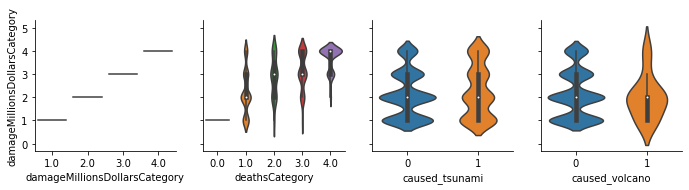

In [161]:
g = sns.PairGrid(eq[['damageMillionsDollarsCategory', 'deathsCategory', 'caused_tsunami', 'caused_volcano']],
                 y_vars='damageMillionsDollarsCategory')
g = g.map(sns.violinplot)

Text(0, 0.5, 'damageMillionsDollarsCategory')

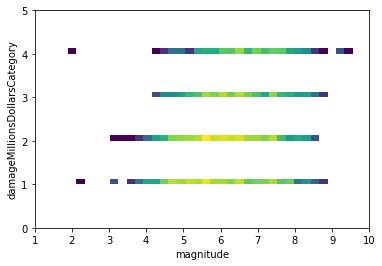

In [187]:
temp = plt.hist2d(eq['magnitude'], eq['damageMillionsDollarsCategory'], range=[[1,10],[0,5]], bins=40, norm=colors.LogNorm())
plt.xlabel('magnitude')
plt.ylabel('damageMillionsDollarsCategory')

In [195]:
# No easy way to fill the missing info from damageMillionsDollarsCategory. Drop missing entries
eq.drop(eq[eq['damageMillionsDollarsCategory'].isnull()].index, inplace=True)

<AxesSubplot:>

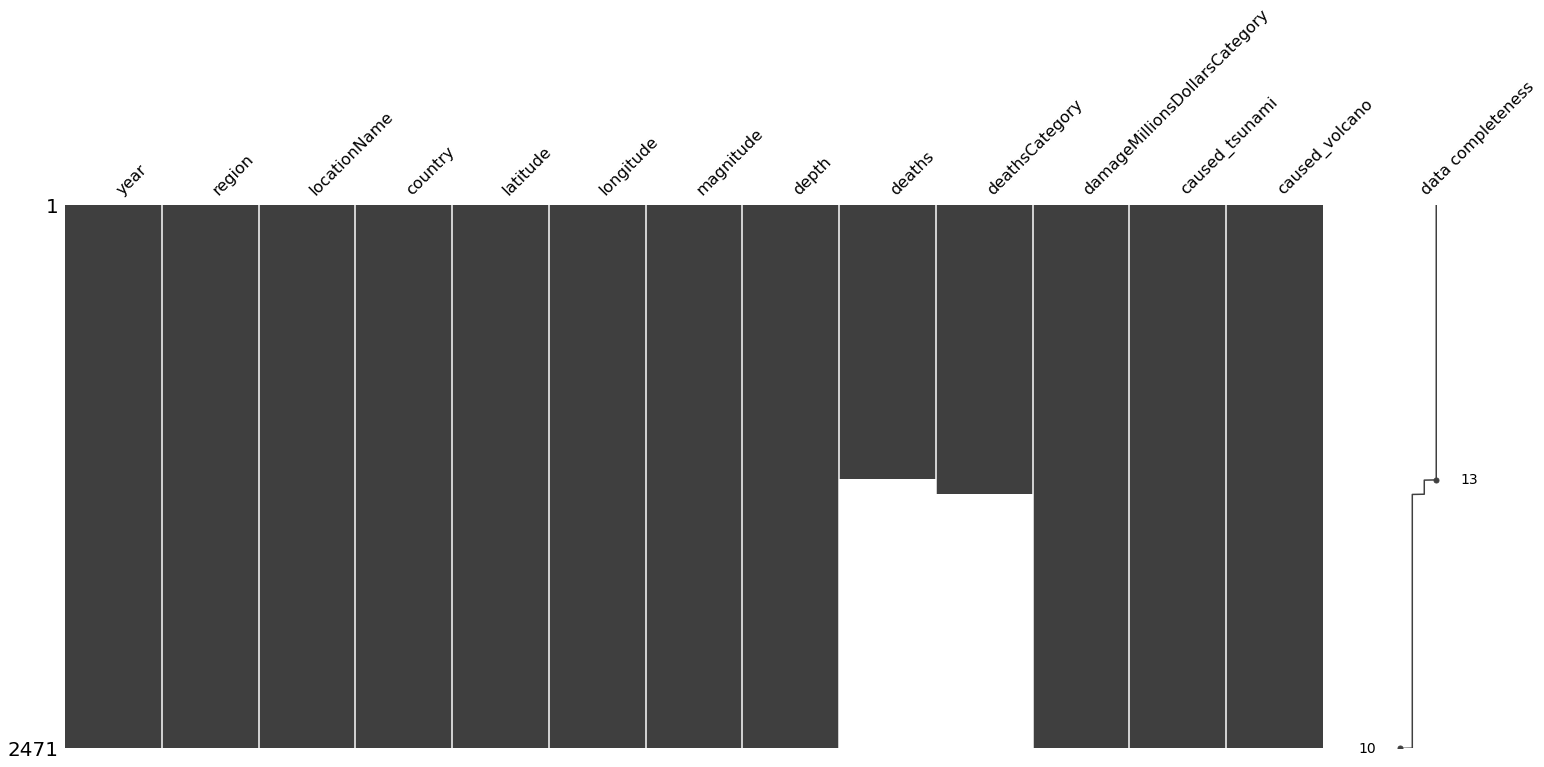

In [196]:
msno.matrix(eq, labels=True, sort='descending')

In [197]:
# Aiming to predict deaths so don't need to worry about missing data there (yet)

## Content

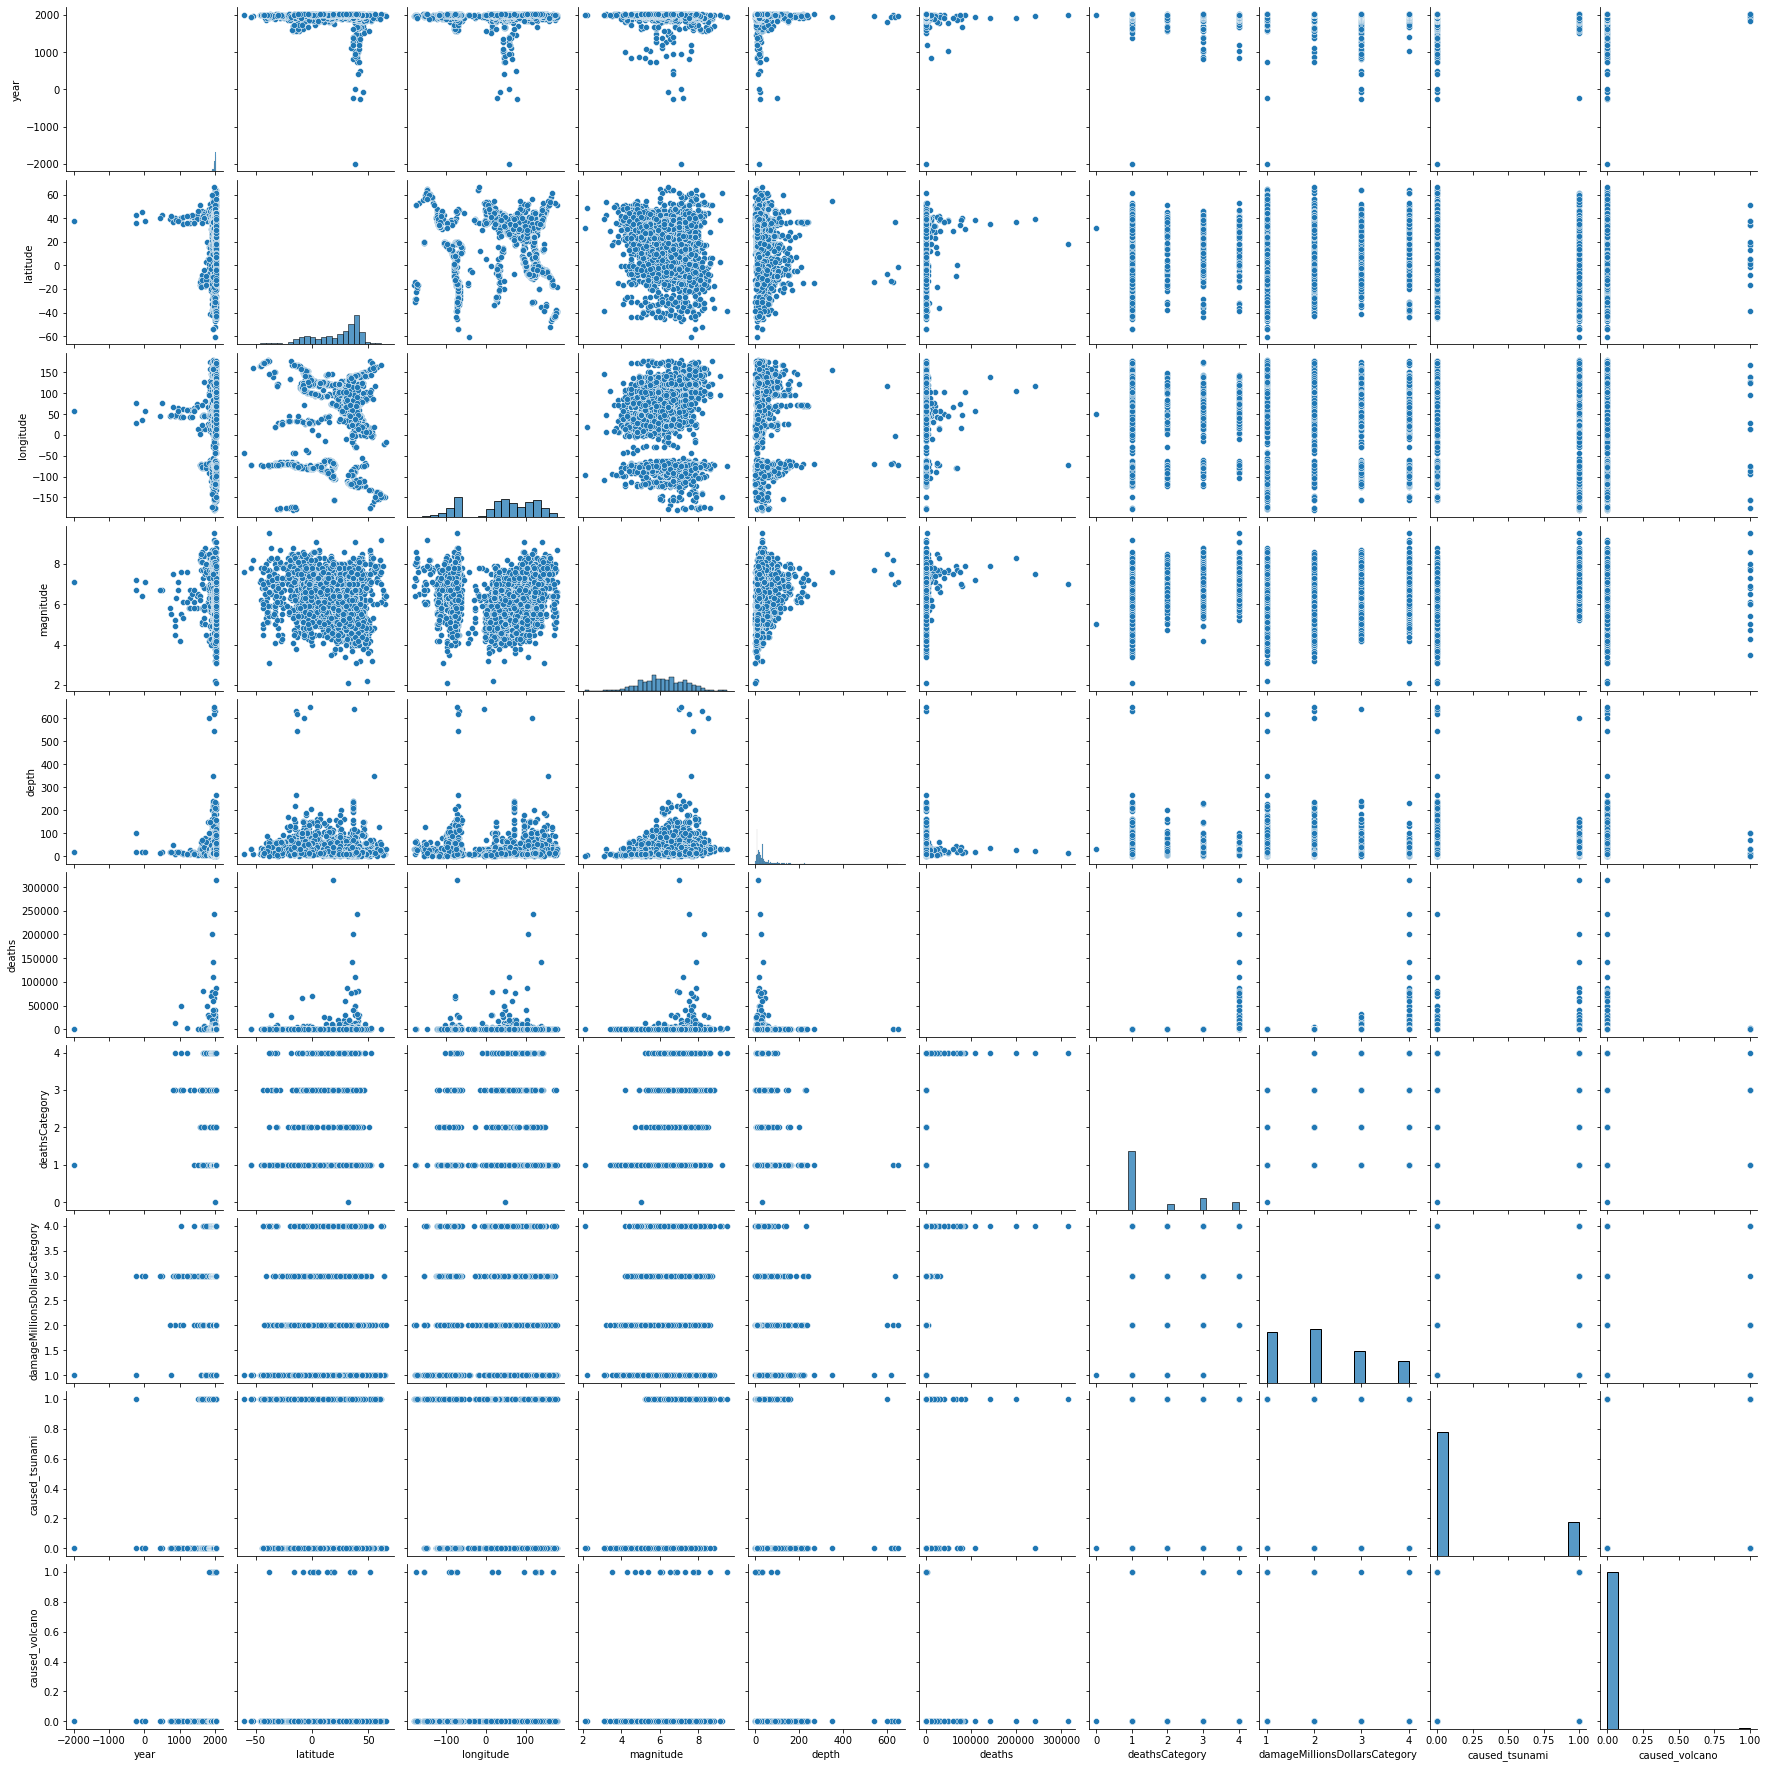

In [198]:
#sns.pairplot(eq)

<AxesSubplot:xlabel='year', ylabel='Count'>

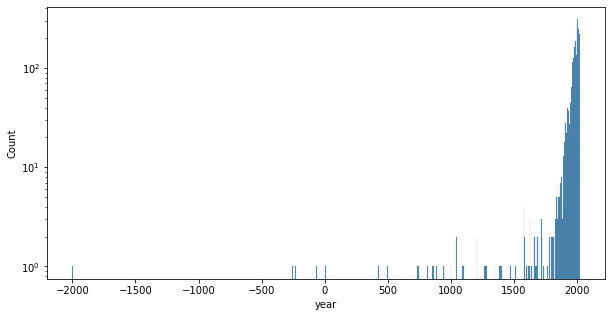

In [221]:
# Majority of recorded earthquakes were from ~1800 onwards
plt.figure(figsize=(10,5))
sns.histplot(data=eq, x='year', log_scale=(False,True))

In [213]:
# Location of each earthquake (colour=magnitude).
# As expected, they tend to lie along tectonic plates.
# Lack of recorded earthquakes around the Atlantic Ocean result in gaps in the data around longitude~-50 (see pairplot)
fig = px.scatter_geo(eq, lat='latitude', lon='longitude', hover_name='year', color='magnitude')
fig.update_layout(title='Earthquakes', title_x=0.5)
fig.update_traces(marker=dict(size=2))
fig.show()

In [209]:
# Earthquakes earlier than the year 1500 seem to be focussed around one region (central/western Asia)
fig = px.scatter_geo(eq[eq['year']<1500], lat='latitude', lon='longitude', hover_name='year', color='magnitude')
fig.update_layout(title='Earthquakes', title_x=0.5)
fig.update_traces(marker=dict(size=5))
fig.show()

<AxesSubplot:xlabel='magnitude', ylabel='Count'>

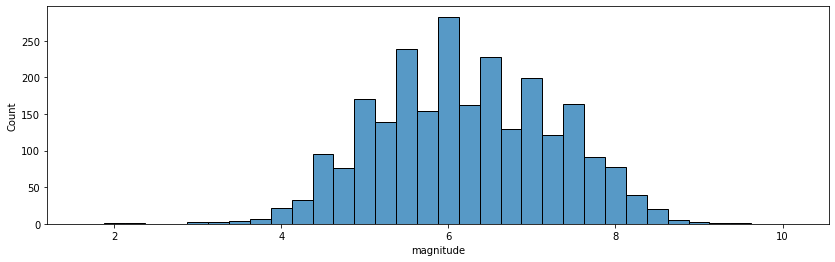

In [236]:
# Recordings in multiples of 0.5 most common. Approx. 6 is the most common magnitude.
plt.figure(figsize=(14,4))
sns.histplot(data=eq, x='magnitude', binwidth=0.25, binrange=(1.625,10))

<AxesSubplot:xlabel='damageMillionsDollarsCategory', ylabel='magnitude'>

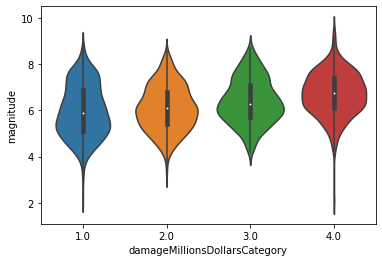

In [250]:
# Larger magnitude tends to lead to more damage, as expected
sns.violinplot(data=eq, x='damageMillionsDollarsCategory', y='magnitude')

<AxesSubplot:xlabel='depth', ylabel='Count'>

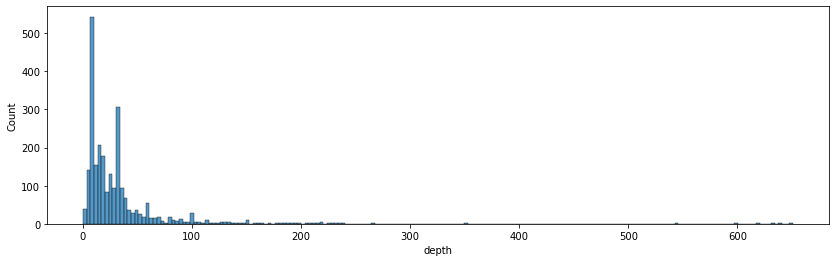

In [239]:
# Majority of earthquakes occur <100km from Earths surface
plt.figure(figsize=(14,4))
sns.histplot(data=eq, x='depth')

<AxesSubplot:xlabel='year', ylabel='depth'>

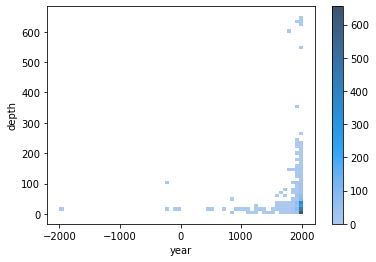

In [247]:
# Most earthquakes at shallow depths (which a quick Google confirms is the case)
sns.histplot(data=eq, x='year', y='depth', bins=60, cbar=True)

<AxesSubplot:xlabel='magnitude', ylabel='depth'>

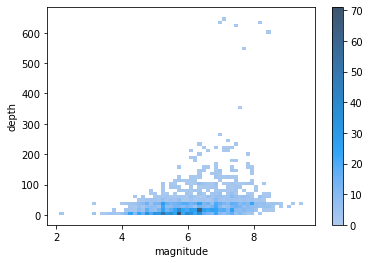

In [248]:
# Deeper earthquakes tend to be higher in magnitude
sns.histplot(data=eq, x='magnitude', y='depth', bins=60, cbar=True)

<AxesSubplot:xlabel='damageMillionsDollarsCategory', ylabel='depth'>

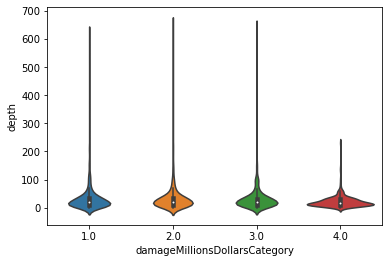

In [251]:
# No obvious relation between depth and damage
sns.violinplot(data=eq, x='damageMillionsDollarsCategory', y='depth')

In [291]:
# Earthquakes leading to tsunamis tend to occur in coastal/oceanic areas, as expected
fig = px.scatter_geo(eq, lat='latitude', lon='longitude', hover_name='year', color='caused_tsunami')
fig.update_layout(title='Earthquakes causing tsunamis', title_x=0.5)
fig.update_traces(marker=dict(size=5))
fig.show()

In [257]:
eq.columns

Index(['year', 'region', 'locationName', 'country', 'latitude', 'longitude',
       'magnitude', 'depth', 'deaths', 'deathsCategory',
       'damageMillionsDollarsCategory', 'caused_tsunami', 'caused_volcano'],
      dtype='object')

In [267]:
# Location of volcanoes can be seen (e.g. Mount Vesuvius in Italy, Hawaii islands...)
# Yellow markers made larger so they can be seen
fig = px.scatter_geo(eq, lat='latitude', lon='longitude', hover_name='locationName', color='caused_volcano')
fig.update_layout(title='Earthquakes causing volcanoes', title_x=0.5)
fig.update_traces(marker=dict(size=(eq['caused_volcano']+1)*5))
fig.show()

In [269]:
# Only 17 earthquakes in the dataset caused volcanoes
eq['caused_volcano'].value_counts()

0    2454
1      17
Name: caused_volcano, dtype: int64

### Target variable

<AxesSubplot:xlabel='deaths', ylabel='Count'>

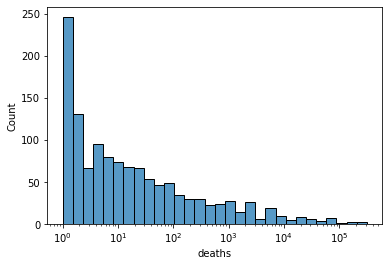

In [273]:
# Very few deaths in most earthquakes
sns.histplot(data=eq, x='deaths', bins=30, log_scale=True)

<AxesSubplot:xlabel='magnitude', ylabel='deaths'>

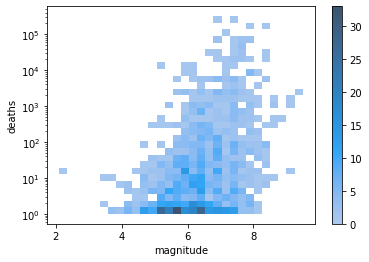

In [277]:
# Number of deaths tends to increase as magnitude increases
sns.histplot(data=eq, y='deaths', x='magnitude', bins=30, log_scale=(False,True), cbar=True)

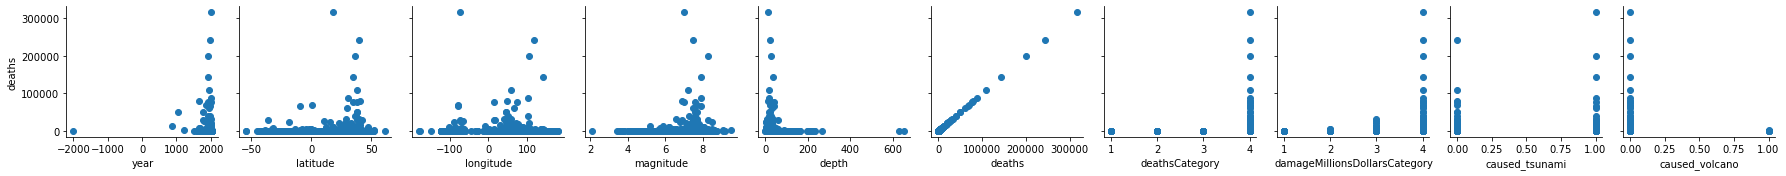

In [283]:
g = sns.PairGrid(eq, y_vars='deaths')
g = g.map(plt.scatter)

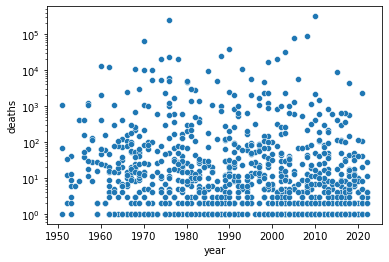

In [289]:
# No correlation between deaths and year (only done most recent years due to lack of non-modern data)
sns.scatterplot(data=eq[eq['year']>1950], x='year', y='deaths')
plt.yscale('log')

In [301]:
# Location of volcanoes can be seen (e.g. Mount Vesuvius in Italy, Hawaii islands...)
# Yellow markers made larger so they can be seen
fig = px.scatter_geo(eq, lat='latitude', lon='longitude', hover_name='locationName', color='deaths')#, log_y=True)
fig.update_layout(title='Earthquakes by number of deaths', title_x=0.5)
fig.update_traces(marker=dict(size=2))
fig.show()

In [302]:
# TODO next: make above plot log scale

## Feature engineering